In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import time

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)

cuda


In [ ]:
seed=1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
batch_size = 64
learning_rate = 0.001

In [ ]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
train_trans = transforms.Compose(
    [
     transforms.RandomResizedCrop((224,224)),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

val_trans = transforms.Compose(
    [
     transforms.Resize((224,224)),
     transforms.CenterCrop((224, 224)),
     transforms.RandomVerticalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(mean, std)
    ]
)

In [ ]:
train_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/train',
                                 transform=train_trans,
                                 )

val_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/val',
                                 transform=val_trans,
                                 )

test_dataset = datasets.ImageFolder(root='/content/drive/MyDrive/dataset/hymenoptera_data/test',
                                 transform=val_trans,
                                 )

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=batch_size,
                        shuffle=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

In [ ]:
class depthwise_block (nn.Module):
    def __init__ (self, in_channels, out_channels, stride, groups=1):
        super(depthwise_block, self).__init__()

        # dw

        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=in_channels,
                               kernel_size=(3,3),
                               stride=stride,
                               padding=(1,1),
                               groups=groups
                               )

        self.bn1 = nn.BatchNorm2d(num_features=in_channels)
        self.relu = nn.ReLU()

        # pw

        self.conv2 = nn.Conv2d(in_channels=in_channels,
                               out_channels=out_channels,
                               kernel_size=(1,1),
                               stride=(1,1),
                               padding=(0,0),
                               )
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

    def forward(self, X):

        out = self.relu(self.bn1(self.conv1(X)))
        out = self.relu(self.bn2(self.conv2(out)))

        return out

class MobilenetV1 (nn.Module):
    def __init__ (self, in_channels, num_classes):
        super(MobilenetV1, self).__init__()

        self.conv = nn.Conv2d(in_channels=in_channels,
                               out_channels=32,
                               kernel_size=(3,3),
                               stride=(2,2),
                               padding=(1,1),
                               )
        self.bn = nn.BatchNorm2d(num_features=32)
        self.relu = nn.ReLU()

        self.dconv1 = depthwise_block(in_channels=32,
                                      out_channels=64,
                                      stride=(1,1),
                                      groups=32)

        self.dconv2 = depthwise_block(in_channels=64,
                                      out_channels=128,
                                      stride=(2,2),
                                      groups=64)

        self.dconv3 = depthwise_block(in_channels=128,
                                      out_channels=128,
                                      stride=(1,1),
                                      groups=128)

        self.dconv4 = depthwise_block(in_channels=128,
                                      out_channels=256,
                                      stride=(2,2),
                                      groups=128)

        self.dconv5 = depthwise_block(in_channels=256,
                                      out_channels=256,
                                      stride=(1,1),
                                      groups=256)

        self.dconv6 = depthwise_block(in_channels=256,
                                      out_channels=512,
                                      stride=(2,2),
                                      groups=256)

        self.dconv7 = depthwise_block(in_channels=512, # 5 times
                                      out_channels=512,
                                      stride=(1,1),
                                      groups=512)

        self.dconv8 = depthwise_block(in_channels=512,
                                      out_channels=1024,
                                      stride=(2,2),
                                      groups=512)

        self.dconv9 = depthwise_block(in_channels=1024,
                                      out_channels=1024,
                                      stride=(1,1),
                                      groups=1024)

        self.avgpool = nn.AvgPool2d(kernel_size=(7,7),
                                    stride=(1,1),
                                    padding=(0,0))

        self.fc = nn.Linear(in_features=1024, out_features=num_classes)

    def forward(self, X):

        # shape of X is torch.Size([1, 3, 224, 224])
        out = self.relu(self.bn(self.conv(X)))
        # torch.Size([1, 32, 112, 112]), stride=2
        out = self.dconv1(out)
        # torch.Size([1, 32, 112, 112]), stride=1
        # torch.Size([1, 64, 112, 112]), stride=1
        out = self.dconv2(out)
        # torch.Size([1, 64, 56, 56])
        # torch.Size([1, 128, 56, 56]) 1st
        out = self.dconv3(out)
        # torch.Size([1, 128, 56, 56]) 2nd
        # torch.Size([1, 128, 56, 56]) 3rd
        out = self.dconv4(out)
        # torch.Size([1, 128, 28, 28])
        # torch.Size([1, 256, 28, 28])
        out = self.dconv5(out)
        out = self.dconv6(out)

        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)
        out = self.dconv7(out)

        out = self.dconv8(out)
        out = self.dconv9(out)

        out = self.avgpool(out)
        out = out.view(out.size(0), 1024*1*1)
        out = self.fc(out)

        return out

In [ ]:
model = MobilenetV1(in_channels=3,
                 num_classes=2).to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/mobilenetv1_on_hymeno.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['model_optimizer'])

In [ ]:
torch.cuda.empty_cache()

In [ ]:
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
def train_loop (model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc):

  for epoch in range(num_epochs):

      model.train()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(train_loader):
          images = images.to(device)
          labels = labels.to(device)
          z_scores = model(images)
          loss = criterion(z_scores, labels)
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          running_loss += loss.item() * images.size(0)
          _, predictions = torch.max(z_scores, 1)
          running_corrects += torch.sum(predictions == labels)

      epoch_loss = running_loss / len(train_dataset)
      epoch_acc = running_corrects / len(train_dataset)
      print(f'Epoch {epoch+1} / {num_epochs}, '
            f'Train Loss {epoch_loss:.4f}, '
            f'Train Acc {epoch_acc:.4f}')

      train_acc_hist.append(epoch_acc)
      loss_train.append(epoch_loss)

      step_lr_scheduler.step()

      model.eval()

      running_loss = 0.0
      running_corrects = 0

      for idx, (images, labels) in enumerate(val_loader):
          images = images.to(device)
          labels = labels.to(device)

          with torch.no_grad():
              z_scores = model(images)
              loss = criterion(z_scores, labels)

              running_loss += loss.item() * images.size(0)
              _, predictions = torch.max(z_scores, 1)
              running_corrects += torch.sum(predictions == labels)

      epoch_loss_val = running_loss / len(val_dataset)
      epoch_acc_val = running_corrects / len(val_dataset)
      print(f'Epoch {epoch + 1} / {num_epochs}, '
            f'Val Loss {epoch_loss_val:.4f}, '
            f'Val Acc {epoch_acc_val:.4f}')

      val_acc_hist.append(epoch_acc_val)
      loss_val.append(epoch_loss_val)

      if epoch_acc_val > best_acc:
          best_acc = epoch_acc_val

In [ ]:
def calculate_time (time_elapsed):
    minutes = time_elapsed // 60
    seconds = time_elapsed % 60
    if minutes > 60:
        hours = minutes // 60
        new_minutes = minutes % 60
        print(f'Training complete in {hours:.0f}h {new_minutes:.0f}m {seconds:.0f}s')
    else:
        print(f'Training complete in {minutes:.0f}m {seconds:.0f}s')

In [ ]:
num_epochs = 30
val_acc_hist = []
train_acc_hist = []
loss_train = []
loss_val = []
best_acc = 0.0

In [ ]:
start = time.time()
train_loop(model, num_epochs, step_lr_scheduler, loss_train, loss_val, train_acc_hist, val_acc_hist, best_acc)
time_elapsed = time.time() - start

Epoch 1 / 30, Train Loss 0.6248, Train Acc 0.6721
Epoch 1 / 30, Val Loss 1.0472, Val Acc 0.4301
Epoch 2 / 30, Train Loss 0.5699, Train Acc 0.7090
Epoch 2 / 30, Val Loss 0.6886, Val Acc 0.5699
Epoch 3 / 30, Train Loss 0.5958, Train Acc 0.6352
Epoch 3 / 30, Val Loss 0.7273, Val Acc 0.4731
Epoch 4 / 30, Train Loss 0.5481, Train Acc 0.7049
Epoch 4 / 30, Val Loss 0.7779, Val Acc 0.4516
Epoch 5 / 30, Train Loss 0.5571, Train Acc 0.7008
Epoch 5 / 30, Val Loss 1.2329, Val Acc 0.4409
Epoch 6 / 30, Train Loss 0.5104, Train Acc 0.7746
Epoch 6 / 30, Val Loss 1.0238, Val Acc 0.4946
Epoch 7 / 30, Train Loss 0.5478, Train Acc 0.7008
Epoch 7 / 30, Val Loss 0.6770, Val Acc 0.6237
Epoch 8 / 30, Train Loss 0.5032, Train Acc 0.7664
Epoch 8 / 30, Val Loss 0.6062, Val Acc 0.6667
Epoch 9 / 30, Train Loss 0.4826, Train Acc 0.7705
Epoch 9 / 30, Val Loss 0.5587, Val Acc 0.6774
Epoch 10 / 30, Train Loss 0.5121, Train Acc 0.7500
Epoch 10 / 30, Val Loss 0.4966, Val Acc 0.7527
Epoch 11 / 30, Train Loss 0.4904, Trai

In [ ]:
calculate_time(time_elapsed)

Training complete in 3m 31s


In [ ]:
print(f'Best validation Accuracy: {best_acc:.4f}')

Best validation Accuracy: 0.0000


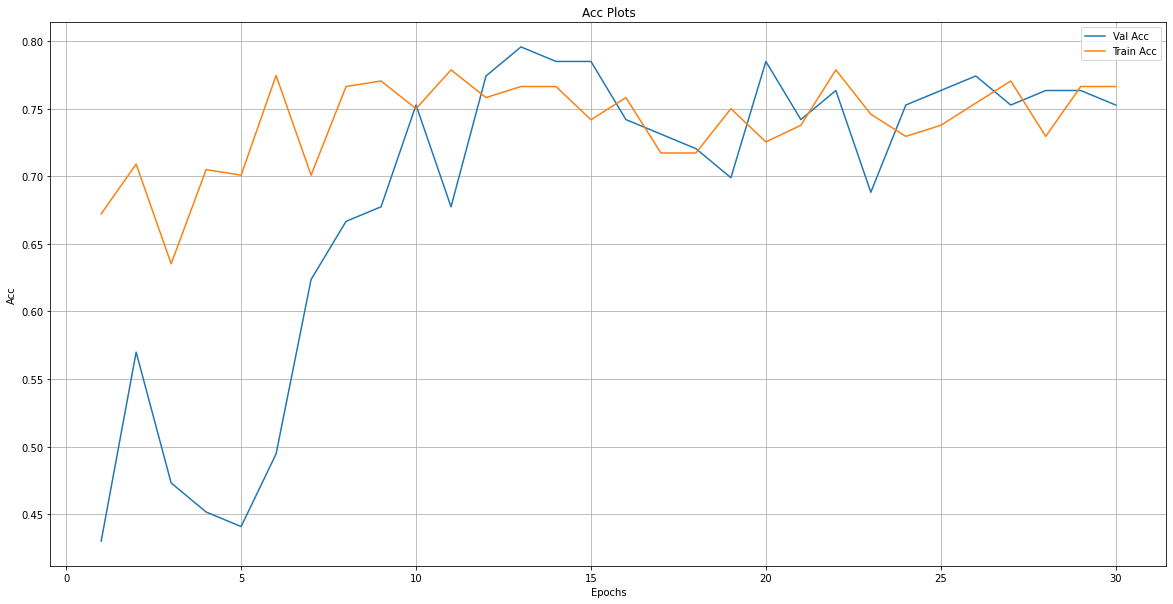

In [ ]:
val_acc_hist_numpy = [acc.cpu().numpy() for acc in val_acc_hist]
train_acc_hist_numpy = [acc.cpu().numpy() for acc in train_acc_hist]
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), val_acc_hist_numpy, label='Val Acc')
plt.plot(range(1, num_epochs+1), train_acc_hist_numpy, label='Train Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.title("Acc Plots")
plt.legend(loc='upper right')
plt.show()

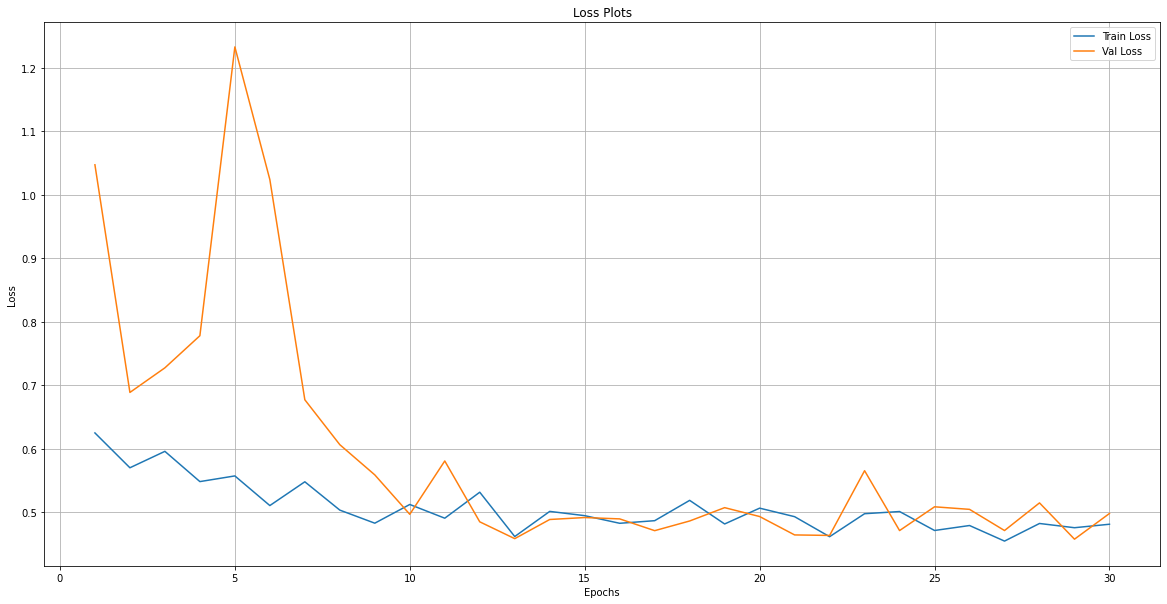

In [ ]:
plt.figure(figsize=(20,10))
plt.grid()
plt.plot(range(1, num_epochs+1), loss_train, label='Train Loss')
plt.plot(range(1, num_epochs+1), loss_val, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
model.eval()

running_corrects = 0

with torch.no_grad():
    for idx, (images, labels) in enumerate(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        z_scores = model(images)

        _, predictions = torch.max(z_scores,1)
        running_corrects += torch.sum(predictions == labels)

    acc = running_corrects / len(test_dataset)
    print(f'Test Accuracy: {acc:.4f}')

Test Accuracy: 0.7000


In [ ]:
checkpoint = {
                'model_state_dict': model.state_dict(),
                'model_optimizer': optimizer.state_dict(),
                'val_acc_hist': val_acc_hist,
                'train_acc_hist': train_acc_hist,
                'loss_train': loss_train,
                'loss_val': loss_val,
                'best_acc': best_acc
}

torch.save(checkpoint, '/content/drive/MyDrive/retrain_mobilenetv1_on_hymeno.pth')